In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uproot, glob, time
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]

analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('../config/Run_Parameters_Xe_Run29.csv')
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']

In [2]:
path_to_reduced = '/p/lustre1/jacopod/29th/TMS_analysis/'
!ls $path_to_reduced

20200207_PreRecirculation    20200212_RecoverY17X19
20200210_AfterRecirculation  20200213_AfterRnInjection
20200211_AfterRecirculation  20200213_DuringRnInjection
20200212_RecirculationOff    notebook


In [3]:
folder_list = ['20200207_PreRecirculation','20200211_AfterRecirculation',\
               '20200212_RecirculationOff', '20200212_RecoverY17X19']

In [4]:
def fit_function(x, A, beta, B, mu_first_peak, sigma_first_peak, C, mu_second_peak, sigma_second_peak):
    return (A * np.exp(-x/beta) +\
            B * np.exp(-1.0 * (x - mu_first_peak)**2 / (2 * sigma_first_peak**2)) +\
            C * np.exp(-1.0 * (x - mu_second_peak)**2 / (2 * sigma_second_peak**2)))

In [5]:
def get_chi2(expected, observed, sigma):
    return np.sum(np.square(expected - observed)/np.square(sigma))

dataframe with 2086590 events loaded in 57.3s
74.25130451031886


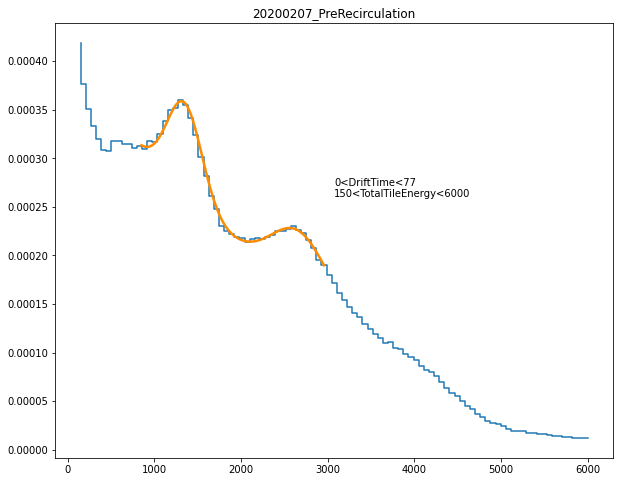

dataframe with 408751 events loaded in 13.6s
115.05734323384894


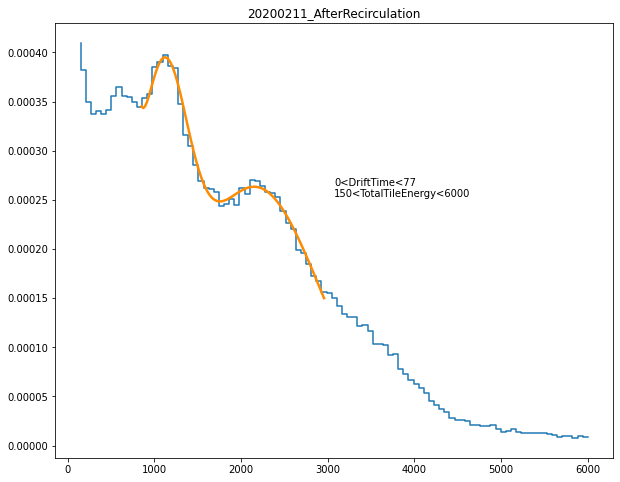

dataframe with 1024298 events loaded in 25.2s
67.42740388866784


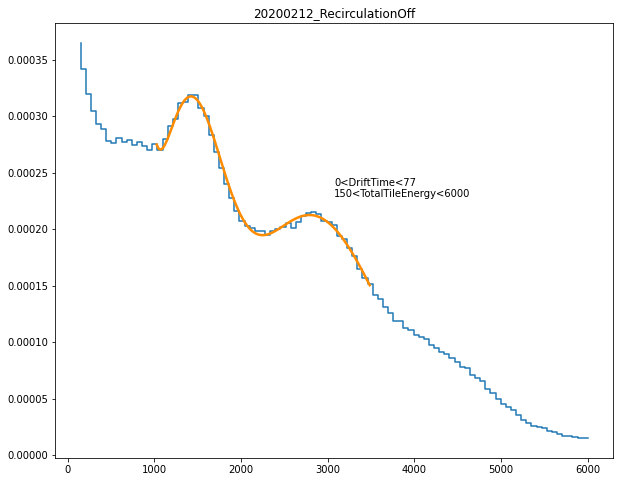

dataframe with 1516775 events loaded in 44.2s
118.22212692220845


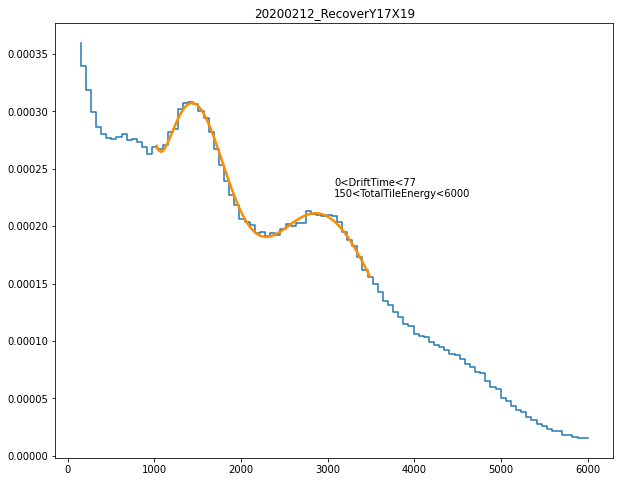

In [6]:
parameter_list = {'values':[], 'errors':[]}
for folder in folder_list:
    if folder == '20200207_PreRecirculation' or folder == '20200211_AfterRecirculation':
        fit_range = [800,3000]
    else:
        fit_range = [1000,3500]
    start_time = time.time()
    df = pd.read_hdf(path_to_reduced + folder + '/reduced_added.h5')
    print('dataframe with {} events loaded in {:.1f}s'.format(df.shape[0],time.time() - start_time))
    DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
    cut_array = ['DriftTime>0', 'DriftTime<77',\
                 'TotalTileEnergy>150', 'TotalTileEnergy<6000']
    derived_dict = {'DriftTime':DriftTime}
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    data, bin_edges = np.histogram(df['TotalTileEnergy'].loc[mask],bins=100,density=True)
    fit_idx = np.where((bin_edges>fit_range[0]) & (bin_edges<fit_range[1]))[0]
    popt, pcov = curve_fit(fit_function, xdata=bin_edges[fit_idx], ydata=data[fit_idx],\
                           p0=[0.1, 200, 0.0001, 1400, 300, 0.0001, 2000, 500])

    parameter_list['values'].append(popt)
    parameter_list['errors'].append(np.sqrt(np.diag(pcov)))
    norm_factor = df.shape[0] * (bin_edges[1] - bin_edges[0])
    chi2 = get_chi2(fit_function(bin_edges[fit_idx], *popt), data[fit_idx], np.sqrt(data[fit_idx]))*norm_factor
    print(chi2)
    x_bin = np.linspace(bin_edges[0],bin_edges[-1],len(data))
    fit_x_bin = np.linspace(bin_edges[fit_idx][0],bin_edges[fit_idx][-1],100)
    plt.step(x_bin,data)
    plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    plt.title(folder)
    plt.text(0.5, 0.6, cut.GetString('\n'), transform = plt.gca().transAxes)
    plt.show()
    
fit_parameters = pd.DataFrame(parameter_list['values'],columns=['A','beta',\
                                                      'ampl_first','position_first','sigma_first',\
                                                      'ampl_second','position_second','sigma_second'])

fit_parameters_error = pd.DataFrame(parameter_list['errors'],columns=['A','beta',\
                                                      'ampl_first','position_first','sigma_first',\
                                                      'ampl_second','position_second','sigma_second'])

chi2 square values shown are not reduced, to obtain the reduced one the dof are 43, giving values ranging from ~1.8 to ~2.8

In [7]:
fit_parameters = np.absolute(fit_parameters)
fit_parameters_error

,A,beta,ampl_first,position_first,sigma_first,ampl_second,position_second,sigma_second
0,0.000006,95.944323,0.000002,3.917461,5.380123,2.949995e-06,8.477730,18.773706
1,88.288212,56.110106,0.000021,29.281098,24.348955,2.191111e-06,27.104887,35.347573
2,13.593296,23.949621,0.000006,11.775739,13.546973,8.601118e-07,13.553718,23.824463
3,16.493833,25.896715,0.000006,12.302127,16.306428,9.432168e-07,14.560289,27.128694


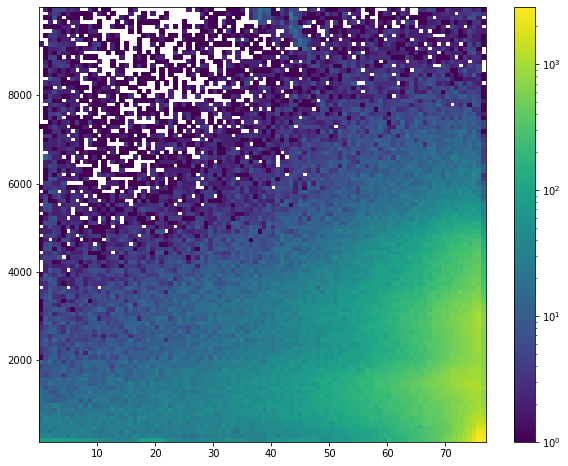

In [19]:
plt.hist2d(DriftTime.loc[mask], df['TotalTileEnergy'].loc[mask], bins=100, norm=LogNorm())
plt.colorbar()

in the next plot I'm looking at the position of the peaks in the different run the bars are the sigma and not the error of the mean, because I wanted to monitor how wide the peaks are to account for possible drift of the peak due to change in purity

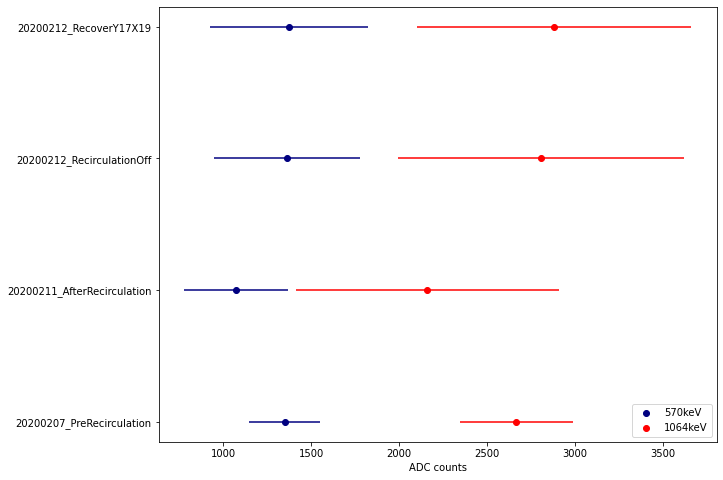

In [8]:
y_value = range(1,len(folder_list)+1)
plt.hlines(y=y_value, xmin=fit_parameters['position_first'] - fit_parameters['sigma_first'],\
           xmax=fit_parameters['position_first'] + fit_parameters['sigma_first'], color='navy')
plt.hlines(y=y_value, xmin=fit_parameters['position_second'] - fit_parameters['sigma_second'],\
           xmax=fit_parameters['position_second'] + fit_parameters['sigma_second'], color='red')
plt.scatter(fit_parameters['position_first'], y_value, color='navy', label='570keV')
plt.scatter(fit_parameters['position_second'], y_value, color='red', label='1064keV')
plt.yticks(y_value, folder_list)
plt.xlabel('ADC counts')
plt.legend(loc='lower right')

here I calculate the ratio between the intensities of the two peaks of the source from the values obtained by the fit. The ratio from the branching ratios is 1.311. This approch, although not extremely robust as very dependent from the parameter of the fit, gives a rough idea on the whether the peaks are in the expected relative intensities

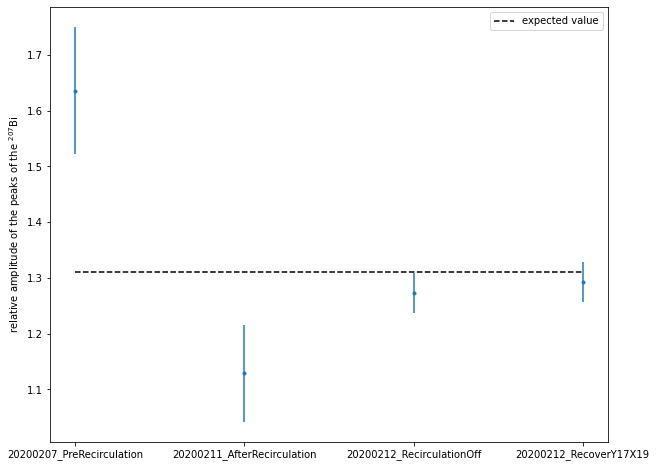

In [9]:
ampl_ratio = fit_parameters['ampl_first']/fit_parameters['ampl_second']
ampl_ratio_error = (fit_parameters_error['ampl_first']/fit_parameters['ampl_first'] +\
fit_parameters_error['ampl_second']/fit_parameters['ampl_second'])*\
fit_parameters['ampl_first']/fit_parameters['ampl_second']
plt.errorbar(y_value,ampl_ratio,ampl_ratio_error,fmt='.')
plt.hlines(1.311, y_value[0], y_value[-1],linestyles='dashed',label='expected value')
plt.xticks(y_value, folder_list)
plt.ylabel('relative amplitude of the peaks of the $^{207}$Bi')
plt.legend()